In [1]:
import GPy
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import rcParams
from sklearn.model_selection import train_test_split
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.transforms import ToUndirected
from torch_geometric.utils import to_undirected
from torch_geometric_temporal.signal import temporal_signal_split
from tqdm import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'
seed = 42
torch.manual_seed(seed)
torch.random.manual_seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
%config InlineBackend.figure_format = 'retina'


torch.Size([50, 1]) torch.Size([50, 1]) torch.Size([50, 1])


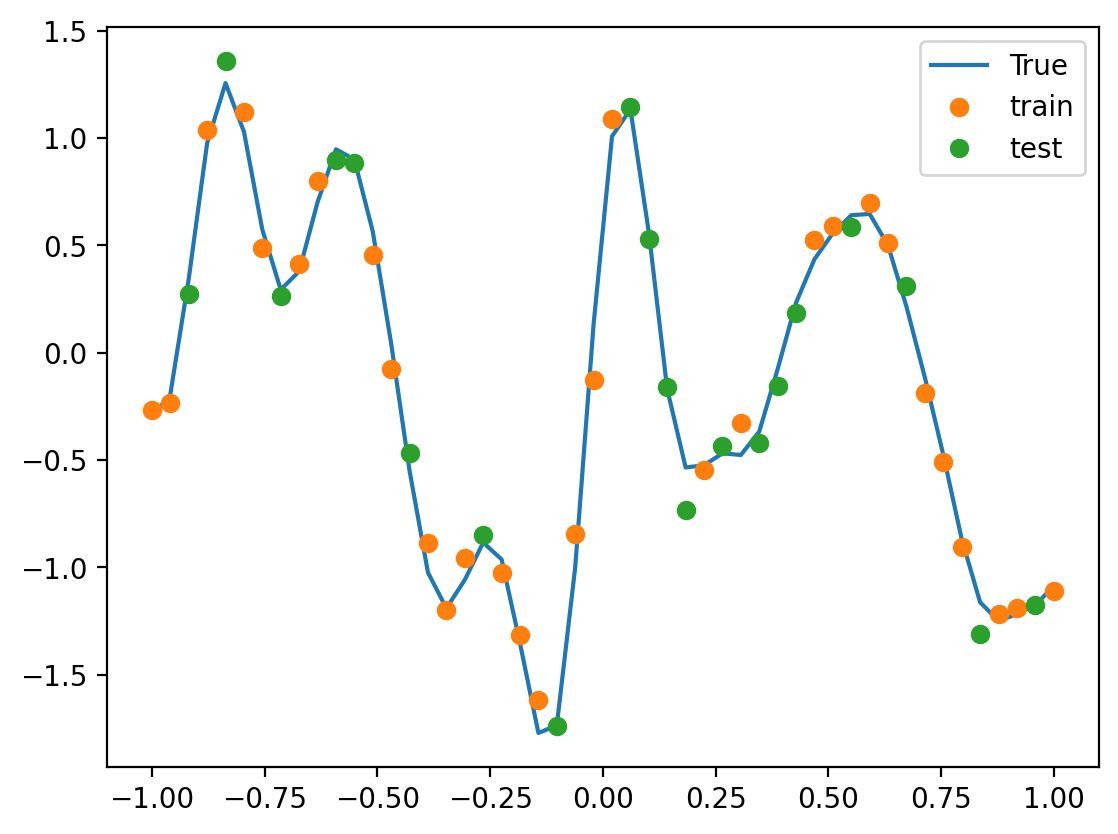

In [2]:
N = 50
x = np.linspace(-1, 1, N).reshape(-1, 1)
kernel = GPy.kern.RBF(input_dim=1, variance=1, lengthscale=0.1)
y = np.random.multivariate_normal(np.zeros(N), kernel.K(x)).reshape(-1, 1)
y_noisy = y + np.random.normal(0, 0.1, N).reshape(-1, 1)

train_x, test_x, train_y, test_y = train_test_split(x, y_noisy, test_size=0.4, random_state=0)

plt.plot(x, y, label="True");
plt.plot(train_x, train_y, 'o', label='train')
plt.plot(test_x, test_y, 'o', label='test')
plt.legend();

x, y, y_noisy = map(lambda x: torch.tensor(x).float().to(device), (x, y, y_noisy))
train_x, test_x, train_y, test_y = map(lambda x: torch.tensor(x).float().to(device), (train_x, test_x, train_y, test_y))
print(x.shape, y.shape, y_noisy.shape)

In [5]:
def get_eucledean_A(x, exponent):
    d = ((x - x.T)**2)**0.5
    # self distance is 0, so replace it with twice of the max distance to give most importance to the current
    d = torch.where(d==0, torch.max(d[d!=0])*2, d)  
    A = 1/(d**exponent)
    return A/A.sum(dim=1, keepdim=True)


In [39]:
def adjacency_matrix_to_edge_list(A):
    edge_list = []
    edge_weights = []
    num_nodes = A.shape[0]
    for i in range(num_nodes):
        for j in range(num_nodes):
            edge_weights.append(A[i, j])
            if A[i, j] != 0:
                edge_list.append((i, j))
    
    return torch.tensor(edge_list).T.to(device), torch.tensor(edge_weights).to(device)


In [40]:
edge_list, edge_weights = adjacency_matrix_to_edge_list(get_eucledean_A(x, 1))

In [44]:
N = 50
D = 2  # Number of dimensions
x = np.random.randn(N, D)
kernel = GPy.kern.RBF(input_dim=D, variance=1, lengthscale=0.1)
y = np.random.multivariate_normal(np.zeros(N), kernel.K(x)).reshape(-1, 1)
y_noisy = y + np.random.normal(0, 0.1, (N, 1))


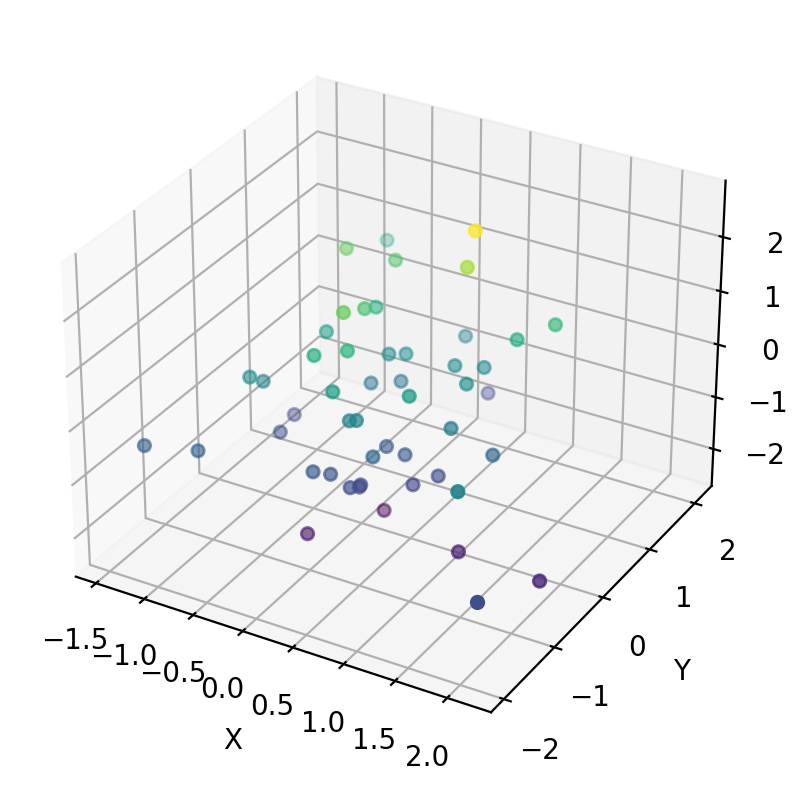

In [45]:
from mpl_toolkits import mplot3d

fig = plt.figure()
ax = plt.axes(projection='3d')

ax.scatter3D(x[:, 0], x[:, 1], y_noisy[:, 0], c=y_noisy[:, 0], cmap='viridis')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()
